In [9]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

merged_df = pd.read_csv('cleaned_data.csv')

# Group product categories per invoice
basket_data = merged_df.groupby('invoice_no')['category'].apply(list).values.tolist()


# Encode transaction list
te = TransactionEncoder()
basket_matrix = te.fit_transform(basket_data)
basket_df = pd.DataFrame(basket_matrix, columns=te.columns_)

# Apply Apriori
frequent_items = apriori(basket_df, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1.0)

# Display top rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))



Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


In [10]:
import numpy as np

# Simulate missing values
merged_df['cost_price'] = merged_df['price'] * 0.7
merged_df['discount_pct'] = np.random.randint(0, 21, size=len(merged_df))
merged_df['discount_amt'] = merged_df['price'] * merged_df['discount_pct'] / 100

# Calculate profit
merged_df['unit_profit'] = merged_df['price'] - merged_df['cost_price'] - merged_df['discount_amt']
merged_df['total_profit'] = merged_df['unit_profit'] * merged_df['quantity']

# Summarize profit by category
profit_summary = merged_df.groupby('category')[['unit_profit', 'total_profit']].mean().sort_values(by='total_profit', ascending=False)
print(profit_summary.round(2))


                 unit_profit  total_profit
category                                  
Technology            634.46       2329.42
Shoes                 360.88       1324.22
Clothing              180.11        660.47
Cosmetics              24.41         89.62
Toys                   21.58         79.13
Books                   9.10         33.49
Souvenir                7.01         25.57
Food & Beverage         3.12         11.48


In [11]:
# Bundle ideas based on association + profit
for _, row in rules.sort_values(by='lift', ascending=False).head(10).iterrows():
    a = ', '.join(list(row['antecedents']))
    c = ', '.join(list(row['consequents']))
    lift = row['lift']

    print(f"🔗 Rule: Customers buying **{a}** also buy **{c}** (Lift: {lift:.2f})")
    
    if c in profit_summary.index:
        profit = profit_summary.loc[c, 'unit_profit']
        print(f"💰 Profit per unit on {c}: ₹{profit:.2f}")
        
        if profit > 300:
            print(f"💡 Recommendation: Bundle {a} + {c} with discount — High profit!\n")
        else:
            print(f"⚠️ Lower profit product — consider bundling for inventory clearance\n")


In [12]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Top 10 association rules
top_rules = rules.sort_values(by='lift', ascending=False).head(10)
for _, row in top_rules.iterrows():
    a = ', '.join(list(row['antecedents']))
    c = ', '.join(list(row['consequents']))
    G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=2500, font_size=10, edge_color='gray')
plt.title("Top Product Association Rules (Apriori)")
plt.show()


ModuleNotFoundError: No module named 'networkx'

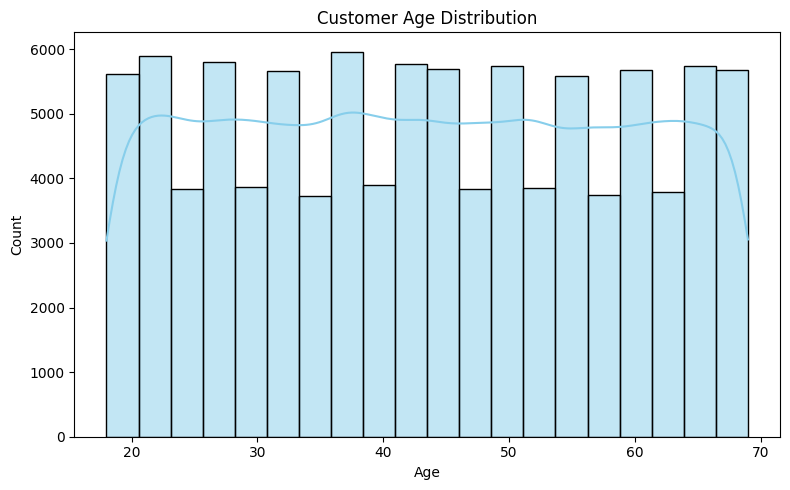

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(merged_df['age'], kde=True, bins=20, color='skyblue')
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


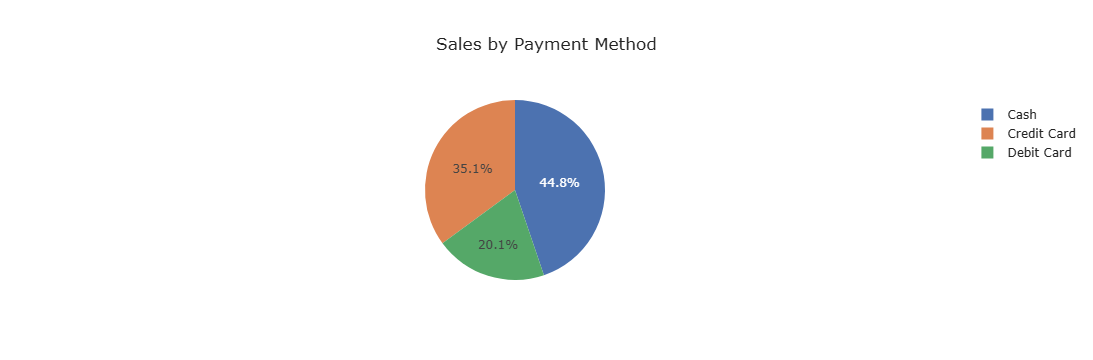

In [19]:

import plotly.express as px

# Optional Seaborn bar
payment_sales = merged_df.groupby('payment_method')['price'].sum().reset_index()

fig = px.pie(payment_sales, names='payment_method', values='price',
             title='Sales by Payment Method',
             template='seaborn')
fig.show()


In [20]:
import plotly.express as px

# Example: Daily sales line chart
daily_sales = merged_df.groupby('invoice_date')['price'].sum().reset_index()

fig = px.line(daily_sales, x='invoice_date', y='price',
              title='Total Sales Over Time',
              labels={'invoice_date': 'Date', 'price': 'Total Sales'},
              template='plotly_dark')

# Save to HTML
fig.write_html("sales_over_time.html")
